In [111]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


from imblearn.over_sampling import SMOTE

import joblib

import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

pd.options.display.max_columns = None

----

# **1. Lectura de datos**

In [2]:
df = pd.read_csv('Processed_UCI_Credit_Card.csv')

In [3]:
df['default.payment.next.month'].sum()/len(df)

0.22125813449023862

In [120]:
df.iloc[0].values

array([ 2.000e+04,  3.913e+03,  3.102e+03,  6.890e+02,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  6.890e+02,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  2.000e+00,  2.000e+00,
       -1.000e+00, -1.000e+00, -2.000e+00, -2.000e+00,  2.400e+01,
        1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,
        1.000e+00,  0.000e+00,  0.000e+00,  1.000e+00])

----

# **2. Pre-procesamiento**

### *2.1. Particion de datos*

In [5]:
X = df.drop('default.payment.next.month', axis = 1)
y = df['default.payment.next.month']

In [6]:
## Train y test
# Realizamos la base de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
## Train y val
# Realizamos la base de validacion
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  random_state=1) # 0.25 x 0.8 = 0.2

### *2.2. Estandarizacion de los datos*

In [7]:
s_scaler = StandardScaler()
X_train_scaled_s = s_scaler.fit_transform(X_train)

In [8]:
mm_scaler = MinMaxScaler()
X_train_scaled_mm = mm_scaler.fit_transform(X_train)

### *2.3. Re-balanceo de datos de entrenamiento*

In [9]:
y_train.sum()/len(y_train)

0.2208131709216308

In [12]:
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_train, y_train)

#### *2.3.1. Estandarizacion de datos Re-balanceados*

In [13]:
s_scaler_res = StandardScaler()
X_train_res_scaled_s = s_scaler_res.fit_transform(X_res)

In [14]:
mm_scaler_res = MinMaxScaler()
X_train_res_scaled_mm = mm_scaler_res.fit_transform(X_res)

*Guardamos todos los scalers en una lista*

In [15]:
scalers = [s_scaler, mm_scaler, s_scaler_res, mm_scaler_res]

----

# **3. Modelos**

In [16]:
weight = {0:(len(y_train) - y_train.sum()), 1:y_train.sum()}

## **3.1. Regresion Logistica**

#### 3.1.1. RL - Standard Scaler

In [17]:
lr_ss = LogisticRegression(max_iter = 500, class_weight=weight)
lr_ss.fit(X_train_scaled_s, y_train);

#### 3.1.2. RL - MinMax Scaler

In [18]:
lr_mms = LogisticRegression(max_iter = 500, class_weight=weight)
lr_mms.fit(X_train_scaled_mm, y_train);

#### 3.1.3. RL - Rebalanceo - Standard Scaler

In [19]:
lr_res_ss = LogisticRegression(max_iter = 500)
lr_res_ss.fit(X_train_res_scaled_s, y_res);

#### 3.1.4. RL - Rebalanceo - MinMax Scaler

In [20]:
lr_res_mms = LogisticRegression(max_iter = 500)
lr_res_mms.fit(X_train_res_scaled_mm, y_res);

*Guardamos los modelos en una lista*

In [21]:
rl_models = [lr_ss, lr_mms, lr_res_ss, lr_res_mms]

## **3.2. Random Forest**

#### 3.2.1. RF - Standard Scaler

In [22]:
rf_ss = RandomForestClassifier(class_weight=weight)
rf_ss.fit(X_train_scaled_s, y_train);

#### 3.2.2. RF - MinMax Scaler

In [23]:
rf_mms = RandomForestClassifier(class_weight=weight)
rf_mms.fit(X_train_scaled_mm, y_train);

#### 3.2.3. RF - Rebalanceo - Standard Scaler

In [24]:
rf_res_ss = RandomForestClassifier()
rf_res_ss.fit(X_train_res_scaled_s, y_res);

#### 3.2.4. RF - Rebalanceo - MinMax Scaler

In [25]:
rf_res_mms = RandomForestClassifier()
rf_res_mms.fit(X_train_res_scaled_mm, y_res);

*Guardamos los modelos en una lista*

In [26]:
rf_models = [rf_ss, rf_mms, rf_res_ss, rf_res_mms]

## **3.3. Gradient Boosting**

#### 3.3.1. GB - Standard Scaler

In [27]:
xgb_ss = XGBClassifier(eval_metric = 'auc')
xgb_ss.fit(X_train_scaled_s, y_train);

/home/ruben/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


#### 3.3.2. GB - MinMax Scaler

In [28]:
xgb_mms = XGBClassifier(eval_metric = 'auc')
xgb_mms.fit(X_train_scaled_mm, y_train);

#### 3.3.3. GB - Rebalanceo - Standard Scaler

In [29]:
xgb_res_ss = XGBClassifier(eval_metric = 'auc')
xgb_res_ss.fit(X_train_res_scaled_s, y_res);

#### 3.3.4. GB - Rebalanceo - MinMax Scaler

In [30]:
xgb_res_mms = XGBClassifier(eval_metric = 'auc')
xgb_res_mms.fit(X_train_res_scaled_mm, y_res);

*Guardamos los modelos en una lista*

In [31]:
xgb_models = [xgb_ss, xgb_mms, xgb_res_ss, xgb_res_mms]

----

# **4. Evaluacion**
Con los datos de validacion

In [32]:
# Escalamos los datos de validacion
scaled_X_vals = []
for scaler in scalers:
    scaled_X_vals.append(scaler.transform(X_val))

In [33]:
y_pred_lr = []
y_pred_rf = []
y_pred_xgb = []

for i, X_val_scaled in enumerate(scaled_X_vals):
    y_pred_lr.append(rl_models[i].predict(X_val_scaled))
    y_pred_rf.append(rf_models[i].predict(X_val_scaled))
    y_pred_xgb.append(xgb_models[i].predict(X_val_scaled))

In [35]:
acc_lr = []
acc_rf = []
acc_xgb = []

pr_lr = []
pr_rf = []
pr_xgb = []

rec_lr = []
rec_rf = []
rec_xgb = []

f1_lr = []
f1_rf = []
f1_xgb = []

for i in range(4):
    
    acc_lr.append(accuracy_score(y_val, y_pred_lr[i]))
    acc_rf.append(accuracy_score(y_val, y_pred_rf[i]))
    acc_xgb.append(accuracy_score(y_val,  y_pred_xgb[i]))
    
    pr_lr.append(precision_score(y_val,  y_pred_lr[i]))
    pr_rf.append(precision_score(y_val,  y_pred_rf[i]))
    pr_xgb.append(precision_score(y_val,  y_pred_xgb[i]))
    
    rec_lr.append(recall_score(y_val, y_pred_lr[i]))
    rec_rf.append(recall_score(y_val, y_pred_rf[i]))
    rec_xgb.append(recall_score(y_val, y_pred_xgb[i]))

    f1_lr.append(f1_score(y_val, y_pred_lr[i]))
    f1_rf.append(f1_score(y_val, y_pred_rf[i]))
    f1_xgb.append(f1_score(y_val, y_pred_xgb[i]))

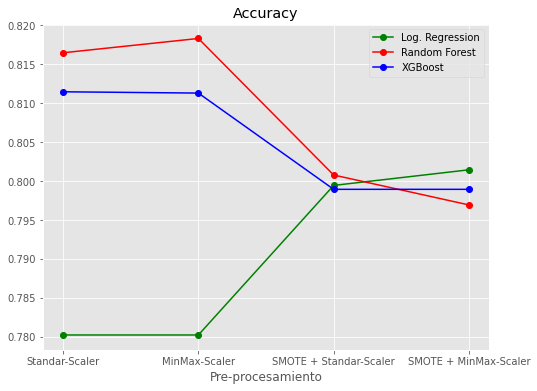

In [52]:
x_labels = ['Standar-Scaler', 'MinMax-Scaler', 'SMOTE + Standar-Scaler', 'SMOTE + MinMax-Scaler']

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(x_labels, acc_lr, '-o', c = 'green')
plt.plot(x_labels, acc_rf, '-o', c = 'red')
plt.plot(x_labels, acc_xgb, '-o', c = 'blue')


ax.legend(['Log. Regression', 'Random Forest', 'XGBoost'])
plt.xlabel('Pre-procesamiento')
plt.title('Accuracy');

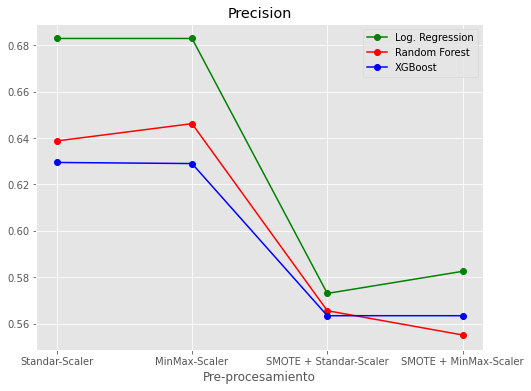

In [54]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(x_labels, pr_lr, '-o', c = 'green')
plt.plot(x_labels, pr_rf, '-o', c = 'red')
plt.plot(x_labels, pr_xgb, '-o', c = 'blue')

ax.legend(['Log. Regression', 'Random Forest', 'XGBoost'])
plt.xlabel('Pre-procesamiento')
plt.title('Precision');

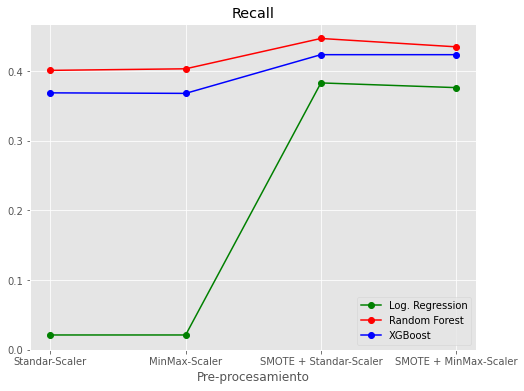

In [55]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(x_labels, rec_lr, '-o', c = 'green')
plt.plot(x_labels, rec_rf, '-o', c = 'red')
plt.plot(x_labels, rec_xgb, '-o', c = 'blue')

ax.legend(['Log. Regression', 'Random Forest', 'XGBoost'])
plt.xlabel('Pre-procesamiento')
plt.title('Recall');

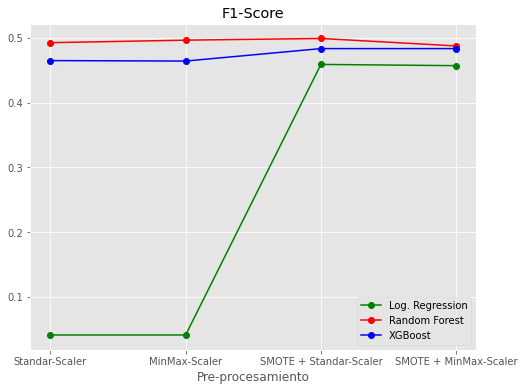

In [56]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(x_labels, f1_lr, '-o', c = 'green')
plt.plot(x_labels, f1_rf, '-o', c = 'red')
plt.plot(x_labels, f1_xgb, '-o', c = 'blue')

ax.legend(['Log. Regression', 'Random Forest', 'XGBoost'])
plt.xlabel('Pre-procesamiento')
plt.title('F1-Score');

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

plt.plot([str(i) for i in range(1,len(data.columns))], accuracy_dt, '-x', c = 'green')
plt.plot([str(i) for i in range(1,len(data.columns))], accuracy_rf, '-o', c = 'red')
plt.plot([str(i) for i in range(1,len(data.columns))], accuracy_xg, '--.', c = 'blue')

ax.legend(['Decision Tree', 'Random Forest', 'XGBoost'])
plt.xlabel('Cantidad de variables')
plt.ylabel('Accuracy');

----

# **5. Sintonizacion de Hiperparametros**
### 5.1. Mejor Regresion Logistica

In [108]:
pipeline_lr = Pipeline([
    ('sc', StandardScaler()),
    ('clf', LogisticRegression(max_iter = 500))
    ])

parameters = {
    'clf__penalty': ['none', 'l2'],
    'clf__C': np.logspace(-4, 4, 10),
}

cv_lr = GridSearchCV(pipeline_lr, param_grid=parameters, verbose=0)
cv_lr.fit(X_res, y_res)

GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=500))]),
             param_grid={'clf__C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'clf__penalty': ['none', 'l2']})

In [103]:
y_pred_final = pd.DataFrame(cv_lr.predict(X_test))
print(
'''
Accuracy: {} \n 
Precision: {} \n 
Recall: {} \n 
F1 Score: {} \n'''.format(accuracy_score(y_test, y_pred_final),
                                  precision_score(y_test, y_pred_final),
                                  recall_score(y_test, y_pred_final),
                                  f1_score(y_test, y_pred_final))
)


Accuracy: 0.7960954446854663 
 
Precision: 0.5605022831050228 
 
Recall: 0.3697289156626506 
 
F1 Score: 0.44555353901996364 



### 5.2. Mejor Random Forest

In [88]:
pipeline_rf = Pipeline([
    ('sc', MinMaxScaler()),
    ('clf', RandomForestClassifier())
    ])

parameters = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__min_samples_split': [2, 10, 100],
    'clf__min_samples_leaf': [1, 5, 10]
}

cv_rf = GridSearchCV(pipeline_rf, param_grid=parameters, verbose=0)
cv_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('sc', MinMaxScaler()),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__min_samples_leaf': [1, 5, 10],
                         'clf__min_samples_split': [2, 10, 100]})

In [92]:
y_pred_final = pd.DataFrame(cv_rf.predict(X_test))
print(
'''
Accuracy: {} \n 
Precision: {} \n 
Recall: {} \n 
F1 Score: {} \n'''.format(accuracy_score(y_test, y_pred_final),
                                  precision_score(y_test, y_pred_final),
                                  recall_score(y_test, y_pred_final),
                                  f1_score(y_test, y_pred_final))
)


Accuracy: 0.8184548640080094 
 
Precision: 0.6621621621621622 
 
Recall: 0.3689759036144578 
 
F1 Score: 0.47388781431334615 



### 5.3. Mejor XGBoost

In [107]:
pipeline_xgb = Pipeline([
    ('sc', MinMaxScaler()),
    ('clf', XGBClassifier(eval_metric = 'auc'))
    ])

parameters = {
    'clf__min_child_weight': [1, 5, 10],
    'clf__gamma': [0.5, 1, 1.5, 2, 5],
    'clf__max_depth': [3, 4, 5]
}

cv_xgb = GridSearchCV(pipeline_xgb, param_grid=parameters, verbose=0)
cv_xgb.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('sc', MinMaxScaler()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='auc',
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                     

In [109]:
y_pred_final = pd.DataFrame(cv_xgb.predict(X_test))
print(
'''
Accuracy: {} \n 
Precision: {} \n 
Recall: {} \n 
F1 Score: {} \n'''.format(accuracy_score(y_test, y_pred_final),
                                  precision_score(y_test, y_pred_final),
                                  recall_score(y_test, y_pred_final),
                                  f1_score(y_test, y_pred_final))
)


Accuracy: 0.8179542799933256 
 
Precision: 0.6612244897959184 
 
Recall: 0.36596385542168675 
 
F1 Score: 0.4711585070285991 



Gana Random Forest!

----

# **6. Guardar el modelo**

In [113]:
model_filepath = 'modelos/model.pkl'
joblib.dump(cv_rf, model_filepath)

['modelos/model.pkl']